In [ ]:
import multiprocessing as mp
from bs4 import BeautifulSoup
import re,queue,os,pickle
from urllib.request import urlopen,urlretrieve
import threading,time,gzip
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.sans-serif']=['SimHei']
%config InlineBackend.figure_format='retina'

# Find Data

In [ ]:
url_base = 'https://sh.lianjia.com'
responce = queue.Queue()
database = []

districts=[]
sub_districts=[]
html = urlopen(url_base+'/ershoufang/').read()
soup = BeautifulSoup(html,features='lxml')
data = soup.find_all('a',{'href':re.compile(r'/ershoufang/(.*)/'),'title':re.compile(r'上海(.*)在售二手房 ')})
for j in data:
    print(j['href'])
    district = j['href']
    districts.append(district)
    html = urlopen(url_base+district).read()
    soup = BeautifulSoup(html,features='lxml')
    sub_district = soup.find_all('a',{'href':re.compile(r'/ershoufang/([a-z]+)/$'),'title':'','rel':'','target':''})
    for d in sub_district:
        if not d['href'] in districts:
            print(d['href'])
            sub_districts.append(d['href'])

In [ ]:
data_housecode = []
last_cnt = 0
for herf in sub_districts:
    for page in range(1,101):
        print(url_base+herf+'pg'+str(page),end='\r')
        html = urlopen(url_base+herf+'pg'+str(page)).read()
        soup = BeautifulSoup(html,features='lxml')
        data = soup.find_all('a',{'class':'img','data-housecode':re.compile(r'[0-9]+'),})
        for i in data:
            data_housecode.append(int(i['data-housecode']))
        data_housecode = list(set(data_housecode))
        if len(data_housecode)==last_cnt:
            break
        last_cnt = len(data_housecode)
    print()
    print(len(data_housecode))

# Download Data

download everything in the list into ./data

In [ ]:
f = gzip.open('data_housecode_list.pkl.gz','rb')
data_housecode = pickle.load(f)
f.close()
len(data_housecode)

In [ ]:
url_base = 'https://sh.lianjia.com'

def download(housecode):
    urlretrieve(url_base+'/ershoufang/'+str(housecode)+'.html','./data/'+str(housecode)+'.html')

In [ ]:
for housecode in range(1000,len(data_housecode)):
    if housecode % 100 == 0:
        print('% 5d / % 5d - %.2f'%(housecode,len(data_housecode),housecode/len(data_housecode))+r'%')
    while len(mp.active_children())>=50:
        time.sleep(0.2)
    p = mp.Process(target=download,args=(data_housecode[housecode],))
    p.start()

# Pre-process data

find useful information in htmls

In [ ]:
listdir = os.listdir('./data/')

In [ ]:
def parse(name,q):
    try:
        soup = BeautifulSoup(open('./data/'+name),features='lxml')
        price = float(soup.find('span',{'class':'total'}).getText())
        if soup.find('span',{'class':'unit'}).getText() == '亿':
            price*=10000

        # location info

        location = soup.find('span',{'class':'info'}).getText()
        #     print(re.split(r'\xa0',location))
        l1,l2,l3 = re.split(r'\xa0',location)

        # room info

        room_soup = soup.find('div',{'class':'room'})

        maininfo = room_soup.find('div',{'class':'mainInfo'}).getText()
        bedroom = int(re.findall(r'([0-9]+)室',maininfo)[0])
        livingroom = int(re.findall(r'([0-9]+)厅',maininfo)[0])

        subinfo = room_soup.find('div',{'class':'subInfo'}).getText()
        floor = re.findall(r'(.+)楼层/',subinfo)
        if len(floor)==0:
            return
        else:
            floor = floor[0]
        totfloor = int(re.findall(r'共([0-9]+)层',subinfo)[0])

        if totfloor <=3 :
            return

        # type info

        type_soup = soup.find('div',{'class':'type'})
        orientation = type_soup.find('div',{'class':'mainInfo'}).getText()
        if orientation == '暂无数据':
            return
        house_type = type_soup.find('div',{'class':'subInfo'}).getText()[-2:]
        if not house_type in ['精装','简装','毛坯']:
            return

        # area info

        area_soup = soup.find('div',{'class':'area'})
        area = float(area_soup.find('div',{'class':'mainInfo'}).getText()[:-2])
        subinfo = area_soup.find('div',{'class':'subInfo'}).getText()
        build_year = re.findall(r'([0-9]+)年建',subinfo)
        if len(build_year)==0:
            return
        else:
            build_year = build_year[0]
        building_type = re.findall(r'/(.+$)',subinfo)[0]
        if not building_type in ['塔楼','板楼']:
            return
        q.put([int(name[:-5]),price,bedroom,livingroom,floor,totfloor,orientation,house_type,area,build_year,building_type,l1,l2,l3])
    except:
        pass

In [ ]:
# data = []
q = mp.Queue()
for name_index in range(10000,len(listdir)):
    name = listdir[name_index]
    if name[-5:] != '.html':
        continue
    if name_index % 16 == 0:
        while not q.empty():
            data.append(q.get())
        print('% 5d / % 5d - %.2f'%(name_index,len(listdir),name_index*100/len(listdir))+r'%  '+name,end='\r')
    while len(mp.active_children())>=8:
        time.sleep(0.1)
    p = mp.Process(target=parse,args=(name,q))
    p.start()

while len(mp.active_children())>0:
    time.sleep(0.2)

while not q.empty():
    data.append(q.get())

In [ ]:
data = pd.DataFrame(data,columns=['name','price','bedroom','livingroom','floor','totfloor','orientation',
                                  'house_type','area','build_year','building_type','location1','location2','location3'])

# pd.get_dummies(data,columns=['floor','building_type','house_type'])
data.to_csv('data.csv',index=False)
data

# Analyze data

plot all data

In [29]:
data = pd.read_csv('data.csv')
data['floor'] = data['floor'].replace(['低','中','高'],['0低','1中','2高'])
data['location3'] = data['location3'].replace(['内环内','内环至中环','中环至外环','外环外'],['1-内环内','2-内环至中环','3-中环至外环','4-外环外'])
data['unit_price'] = data['price'] / data['area']
col = data.columns.values
print(col)

['name' 'price' 'bedroom' 'livingroom' 'floor' 'totfloor' 'orientation'
 'house_type' 'area' 'build_year' 'building_type' 'location1' 'location2'
 'location3' 'unit_price']


In [30]:
subdata = data[data['price'] <= 1000]
continues = ['price','area','unit_price','totfloor','build_year']
separate = ['bedroom','livingroom','floor','orientation','house_type','building_type','location1','location3']
for j in continues:
    for i in separate:
        if i == j:
            continue
        x_label = i
        y_label = j
        print(y_label+' - '+x_label)
        fig = plt.figure()
        if x_label == 'location3':
            sns.boxplot(subdata[x_label],subdata[y_label],order=['1-内环内','2-内环至中环','3-中环至外环','4-外环外'])
        else:
            sns.boxplot(subdata[x_label],subdata[y_label])
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('./plots_small/'+y_label+'-'+x_label+"_box_small.jpg",dpi=200)
        plt.close()
        fig = plt.figure()
        plt.scatter(subdata[x_label],subdata[y_label],alpha=0.005)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('./plots_small/'+y_label+'-'+x_label+"_sca_small.jpg",dpi=200)
        plt.close()
    for i in continues:
        if i == j:
            continue
        x_label = j
        y_label = i
        print(y_label+' - '+x_label)
        fig = plt.figure()
        plt.scatter(subdata[x_label],subdata[y_label],alpha=0.005)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('./plots_small/'+y_label+'-'+x_label+"_sca_small.jpg",dpi=200)
        plt.close()

price - bedroom
price - livingroom
price - floor
price - orientation
price - house_type
price - building_type
price - location1
price - location3
area - price
unit_price - price
totfloor - price
build_year - price
area - bedroom
area - livingroom
area - floor
area - orientation
area - house_type
area - building_type
area - location1
area - location3
price - area
unit_price - area
totfloor - area
build_year - area
unit_price - bedroom
unit_price - livingroom
unit_price - floor
unit_price - orientation
unit_price - house_type
unit_price - building_type
unit_price - location1
unit_price - location3
price - unit_price
area - unit_price
totfloor - unit_price
build_year - unit_price
totfloor - bedroom
totfloor - livingroom
totfloor - floor
totfloor - orientation
totfloor - house_type
totfloor - building_type
totfloor - location1
totfloor - location3
price - totfloor
area - totfloor
unit_price - totfloor
build_year - totfloor
build_year - bedroom
build_year - livingroom
build_year - floor
bui

In [32]:
subdata = data[data['price'] <= 5900]
# continues = ['price','area','unit_price','totfloor']
# separate = ['bedroom','livingroom','floor','orientation','house_type','building_type','location1','location3']
for j in continues:
    for i in separate:
        if i == j:
            continue
        x_label = i
        y_label = j
        print(y_label+' - '+x_label)
        fig = plt.figure()
        if x_label == 'location3':
            sns.boxplot(subdata[x_label],subdata[y_label],order=['1-内环内','2-内环至中环','3-中环至外环','4-外环外'])
        else:
            sns.boxplot(subdata[x_label],subdata[y_label])
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('./plots/'+y_label+'-'+x_label+"_box.jpg",dpi=200)
        plt.close()
        fig = plt.figure()
        plt.scatter(subdata[x_label],subdata[y_label],alpha=0.005)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('./plots/'+y_label+'-'+x_label+"_sca.jpg",dpi=200)
        plt.close()
    for i in continues:
        if i == j:
            continue
        x_label = j
        y_label = i
        print(y_label+' - '+x_label)
        fig = plt.figure()
        plt.scatter(subdata[x_label],subdata[y_label],alpha=0.005)
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.savefig('./plots/'+y_label+'-'+x_label+"_sca.jpg",dpi=200)
        plt.close()

price - bedroom
price - livingroom
price - floor
price - orientation
price - house_type
price - building_type
price - location1
price - location3
area - price
unit_price - price
totfloor - price
build_year - price
area - bedroom
area - livingroom
area - floor
area - orientation
area - house_type
area - building_type
area - location1
area - location3
price - area
unit_price - area
totfloor - area
build_year - area
unit_price - bedroom
unit_price - livingroom
unit_price - floor
unit_price - orientation
unit_price - house_type
unit_price - building_type
unit_price - location1
unit_price - location3
price - unit_price
area - unit_price
totfloor - unit_price
build_year - unit_price
totfloor - bedroom
totfloor - livingroom
totfloor - floor
totfloor - orientation
totfloor - house_type
totfloor - building_type
totfloor - location1
totfloor - location3
price - totfloor
area - totfloor
unit_price - totfloor
build_year - totfloor
build_year - bedroom
build_year - livingroom
build_year - floor
bui

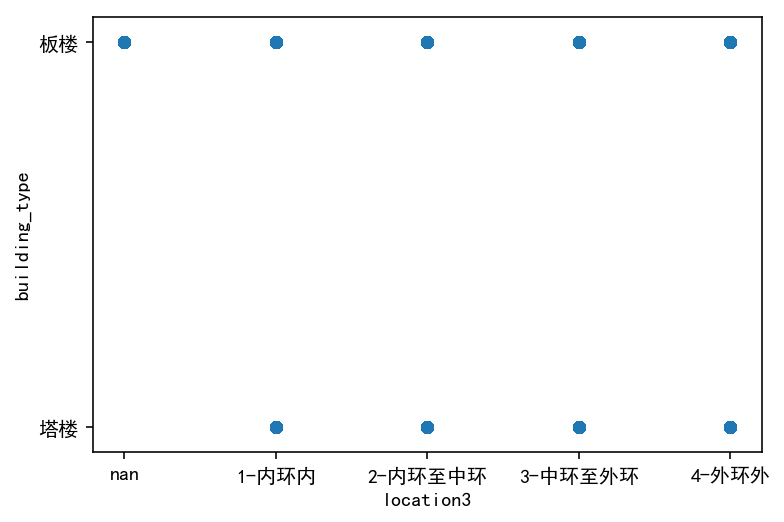

In [42]:
x_label='location3'
y_label='building_type'
fig = plt.figure()
plt.scatter(subdata[x_label],subdata[y_label],alpha=0.002)
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.savefig('./plots_small/'+y_label+'-'+x_label+"_sca_small.jpg",dpi=200)
# plt.close()

In [39]:
data[data['bedroom']==8]

,name,price,bedroom,livingroom,floor,totfloor,orientation,house_type,area,build_year,building_type,location1,location2,location3,unit_price
511,107000359437,3600.0,8,6,2高,29,南,简装,374.02,2006,板楼,浦东,源深,1-内环内,9.625154
2732,107000344717,750.0,8,2,2高,6,南,精装,163.41,2006,板楼,松江,松江新城,4-外环外,4.589682
6864,107001429171,3000.0,8,2,2高,20,南,精装,408.01,2006,板楼,闵行,金虹桥,2-内环至中环,7.352761
17466,107002272897,800.0,8,0,2高,23,南,精装,245.98,2003,板楼,黄浦,蓬莱公园,1-内环内,3.252297
39370,107000070329,2100.0,8,3,0低,6,南,精装,422.00,2006,板楼,闵行,金汇,3-中环至外环,4.976303
